# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, check_shutter_open, 
    get_each_frame_intensity, get_avg_img, load_data, load_mask,get_fields, reverse_updown, 
    apply_mask, show_img,check_ROI_intensity,run_time, cal_g2, 
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists )

 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask,get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,get_t_iq,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate, plot_saxs_two_g2)

from chxanalys.Two_Time_Correlation_Function import Get_Pixel_Array, auto_two_Array,show_C12, get_one_time_from_two_time

 


%matplotlib notebook

## Make a directory for saving results

In [3]:
CYCLE = '2016_2'

username = getpass.getuser()

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/fluerasu/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [4]:
uid = '77d23e' # CoralPor series 10k frames x 0.01s
uid = 'ad2d24' # Si colloids, bds: 15x15 pre-kin: .05x.08
uid = 'fcdba400-4b7e' # Si colloids, bds: 15x15 pre-kin: .05x.08 faster series (0.005s)
#uid = '012be76c-af98' # Si colloids, bds: 15x15 pre-kin: .05x.08 5k x .01s
#uid = 'ea3b4e1f-1234' # Si colloids, bds: 15x15 pre-kin: .07x.08 10k x .01s
uid = 'b5feeb' #Measurement: Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08 
               #Note: we used thins data for Sameera's paper
    
# uid = 'd87499' #Measurement: Silica 10k fr x .00133 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08

# Don't Change these lines below here

In [5]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1846--b5feeb96-cdb0-455f-b078-1b6052326c27--/XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192


In [6]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192_master.h5


In [7]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [8]:
md

{'beam_center_x': 1232.0,
 'beam_center_y': 903.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'framerate': 499.99997625127548,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [9]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

#center = [  1338, 2167 - 424  ]  # center of the speckle pattern

center = [   1227,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)



[1261, 1227]


In [10]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [11]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.00199,
 'uid': 'b5feeb'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [12]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'fcdba400-4b7e_mask.npy'

<IPython.core.display.Javascript object>


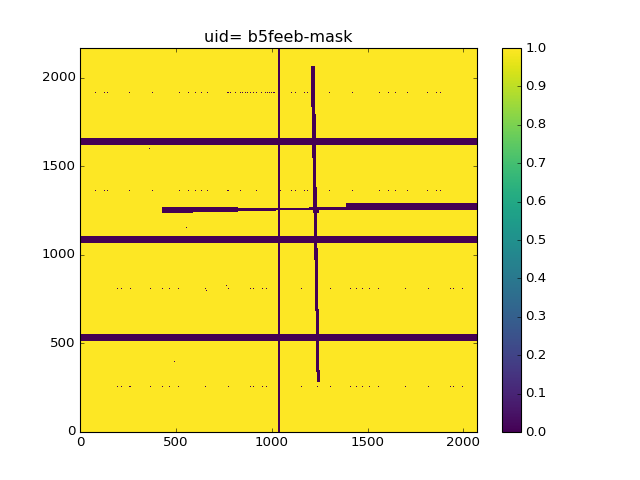

In [13]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [14]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


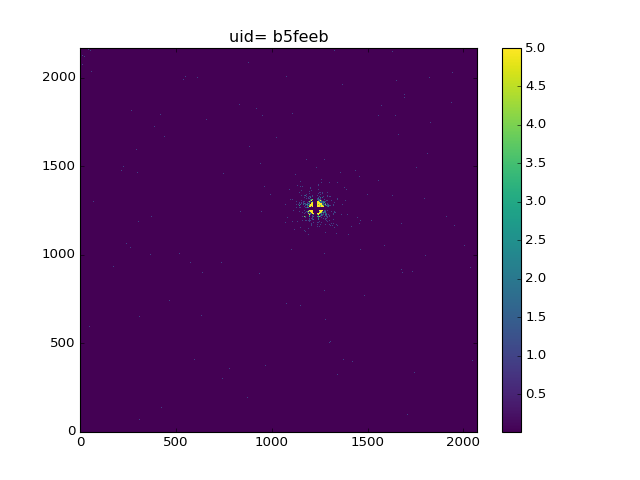

In [15]:
show_img( imgsa[0],  vmin=0.01, vmax=5, logs=False, image_name= 'uid= %s'%uid) 

## Clean Data
* Check shutter open frame to get good time series
* Find bad frames by checking total scattering intensity 


In [16]:
good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,1], plot_ = False )

The first frame with open shutter is : 0


In [17]:
good_series = apply_mask( imgsa[good_start:], mask )

100%|██████████| 10000/10000 [15:23<00:00, 10.83it/s]


<IPython.core.display.Javascript object>


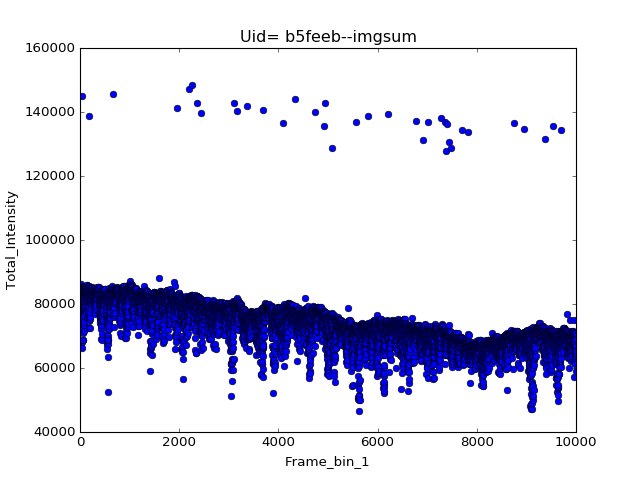

No bad frames are involved.


In [18]:
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1, 
                                bad_pixel_threshold=1.2e8,  plot_ = True, uid=uid)

## Get intensity average image

<IPython.core.display.Javascript object>


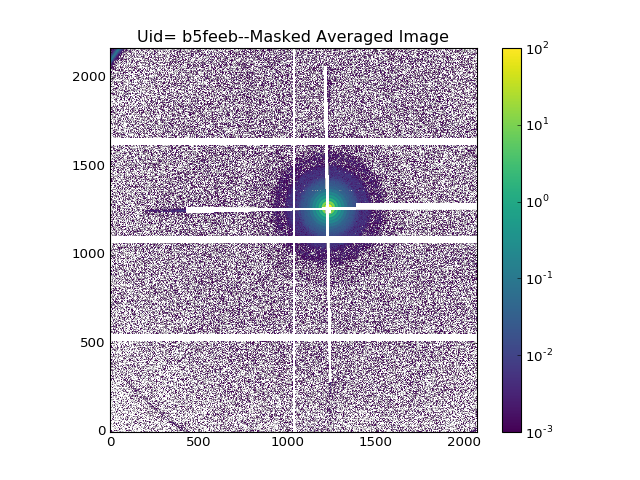

In [19]:
avg_img =  get_avg_img( good_series, sampling = 10, plot_ = True, uid =uid)

## Get circular average 
* Do plot and save q~iq


In [20]:
hmask = create_hot_pixel_mask( avg_img, 1e8)

<IPython.core.display.Javascript object>


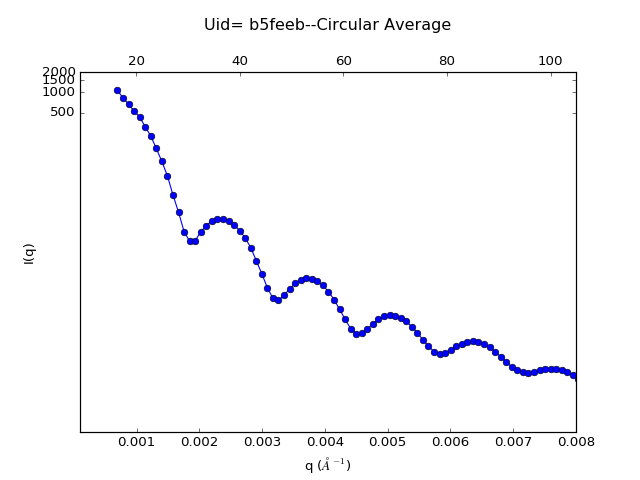

In [21]:
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                    plot_ = True, plot_qinpixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

In [172]:
save_lists( [q,iq], ['q','iq'], filename= 'I(q)-uid=%s'%uid, path=data_dir)

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings

In [22]:
inner_radius= 15
outer_radius = 105
width = 6
num_rings = 14


In [23]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs   )

<IPython.core.display.Javascript object>


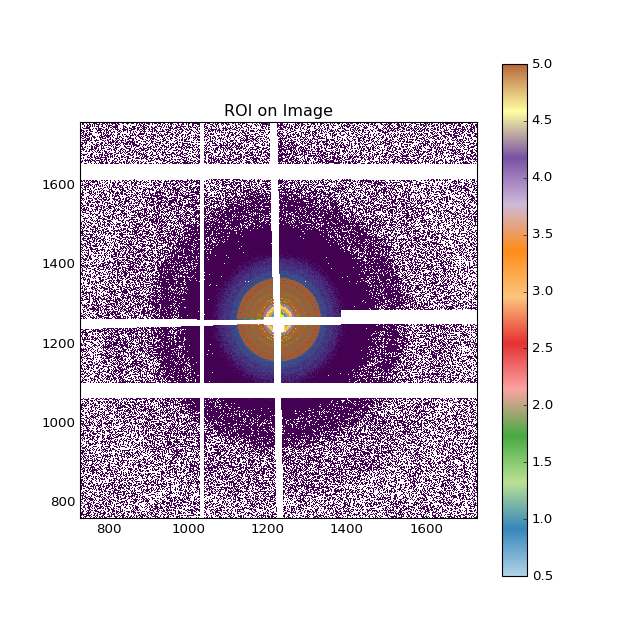

In [26]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=500, alpha=.9)

<IPython.core.display.Javascript object>


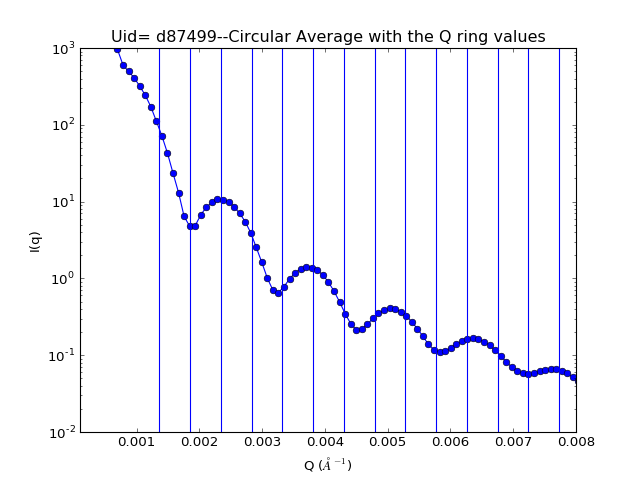

In [176]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.008], ylim = [0.01, 1000])

## Check one ring intensity

<IPython.core.display.Javascript object>


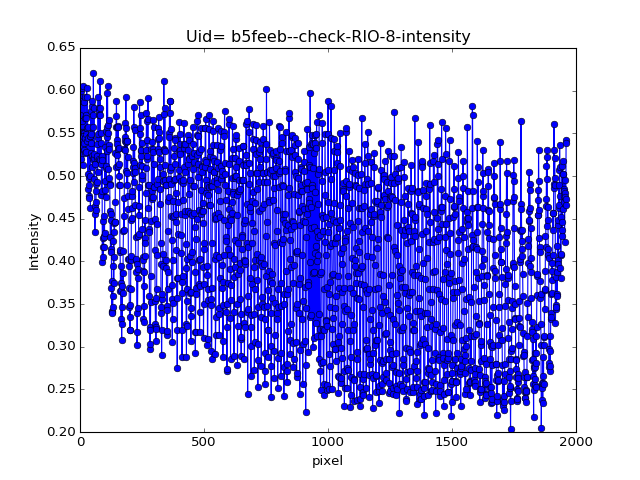

In [25]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 8, uid =uid )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [27]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width=10, edges = None )

<IPython.core.display.Javascript object>


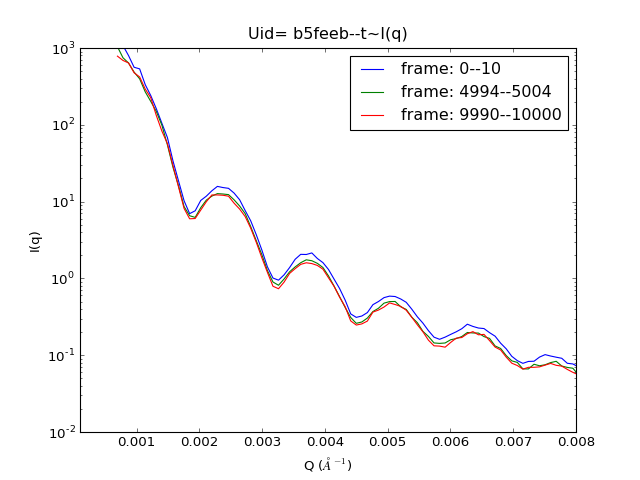

In [28]:
qp, iqs, q = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,   xlim=[0.0001,.008], ylim = [0.01, 1000])

<IPython.core.display.Javascript object>


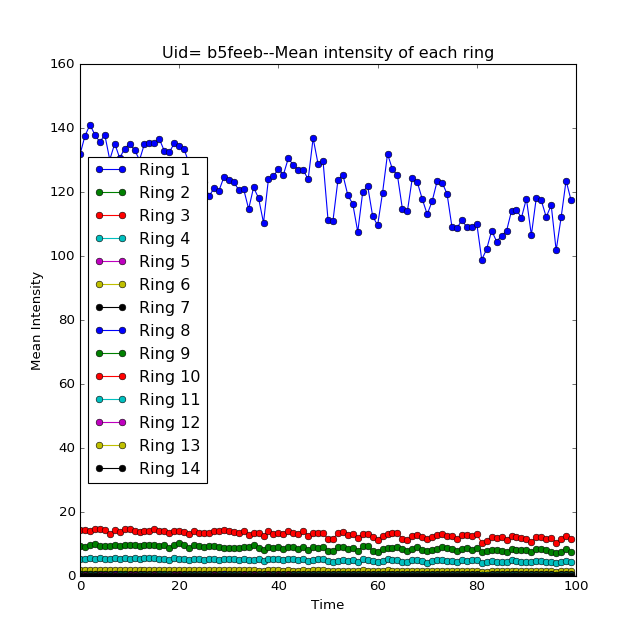

In [29]:
mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = 100,
                                timeperframe = md['frame_time'], plot_ = True, uid = uid  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [30]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

False

### if define another good_series

In [31]:
if False:
    good_start = 1
    good_end = len( imgs )
    good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

In [32]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--12--
10000 frames will be processed...


100%|██████████| 10000/10000 [15:19<00:00, 10.88it/s]

G2 calculation DONE!
Total time: 15.32 min


In [33]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [34]:
save_saxs_g2(   g2, res_pargs )

The g2 is saved in /XF11ID/analysis/2016_2/fluerasu/Results/ with filename as g2-uid=b5feeb-20160706-1627-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


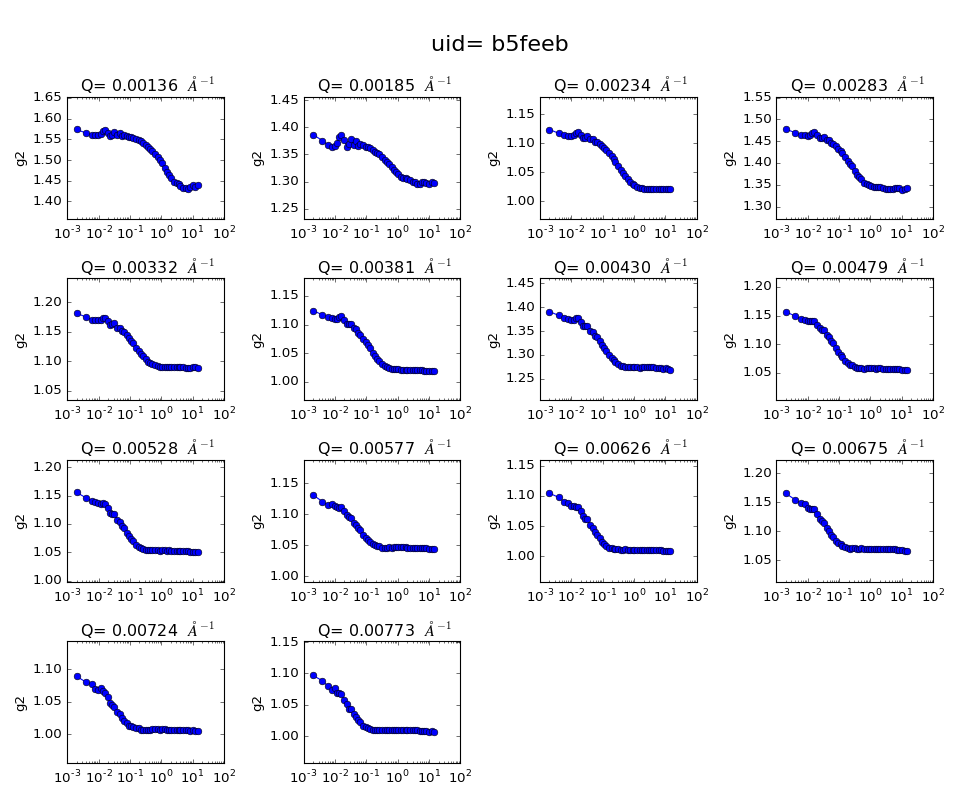

In [35]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)              
#plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05],qz_center=qz_center, qr_center=qr_center,uid = uid, path=path )

# Fit g2

In [36]:
fit= True

<IPython.core.display.Javascript object>


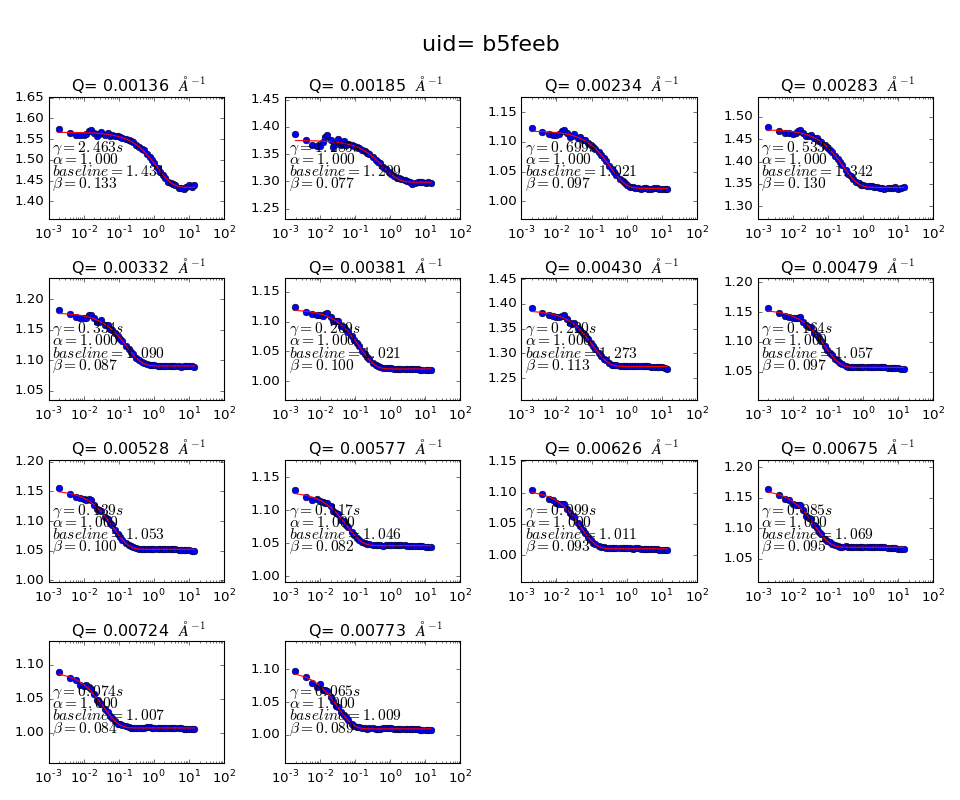

In [43]:
if fit:
    #result = fit_saxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)
    #result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05],)
    result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                         fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                         guess_values={'baseline':1.0,'beta':0.1,'alpha':1.0,'relaxation_rate':0.01})
   

The fitted diffusion coefficient D0 is:  2.59E+05   A^2S-1


<IPython.core.display.Javascript object>


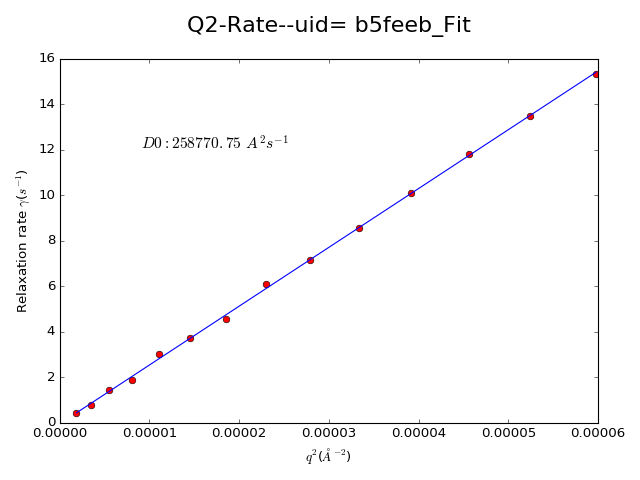

array([  2.58770746e+05,  -5.09789742e-02])

In [44]:
fit_q2_rate(  q_ring_center**2, result['rate'], uid=uid, path= data_dir )

In [45]:
#result

# For two-time

In [46]:
run_two_time = True #False

In [47]:
if run_two_time:    
    qind, pixelist = roi.extract_label_indices(  ring_mask  )
    #good_start = 10
    #good_end = 300 #len( imgs )
    #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    run_time(t0)
    g12b = auto_two_Array( good_series, ring_mask, data_pixel = data_pixel ) 

  0%|          | 0/14 [00:00<?, ?it/s]

Total time: 13.75 min


100%|██████████| 14/14 [01:17<00:00,  6.58s/it]

Total time: 1.29 min


In [49]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)
    taus2 = np.arange( g2b.shape[0]) *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe, filename='g2_from_two-time')

The g2 is saved in /XF11ID/analysis/2016_2/fluerasu/Results/ with filename as g2_from_two-time-uid=b5feeb-20160706-1652-.csv


<IPython.core.display.Javascript object>


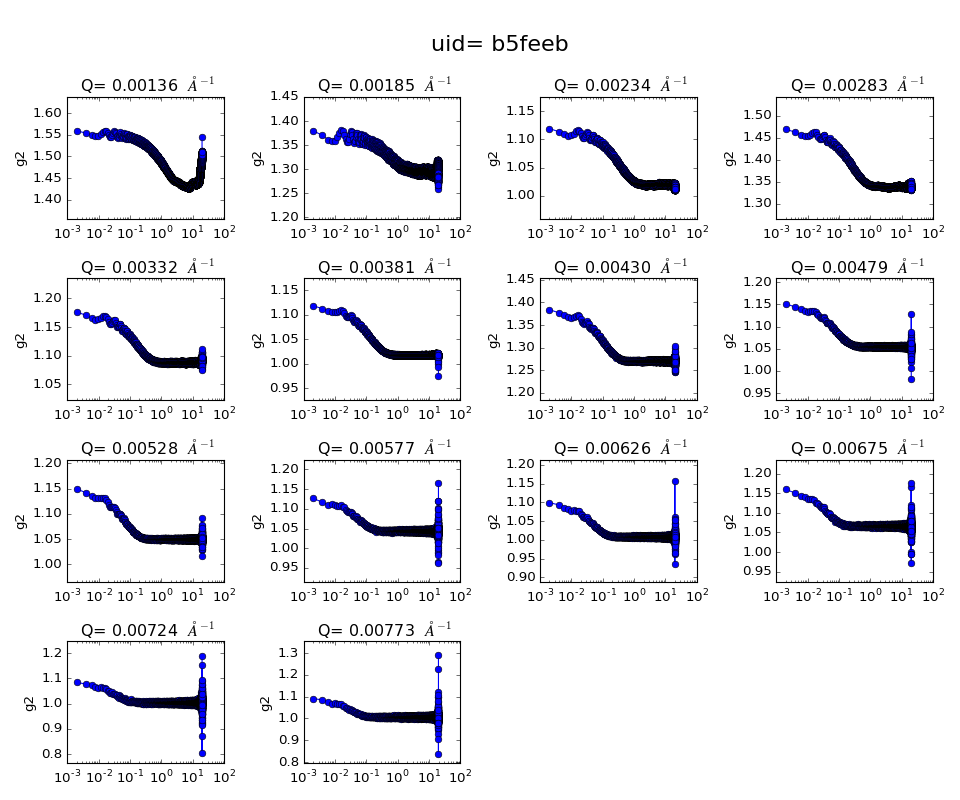

In [50]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)   

<IPython.core.display.Javascript object>


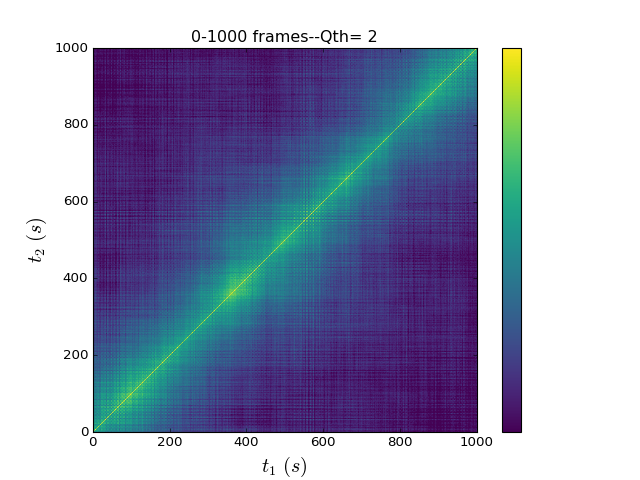

In [51]:
if run_two_time:
    show_C12(g12b, q_ind=2, N1=0, N2=1000, vmin=1.006, vmax=1.2,  )

In [52]:
#g12b.shape

<IPython.core.display.Javascript object>


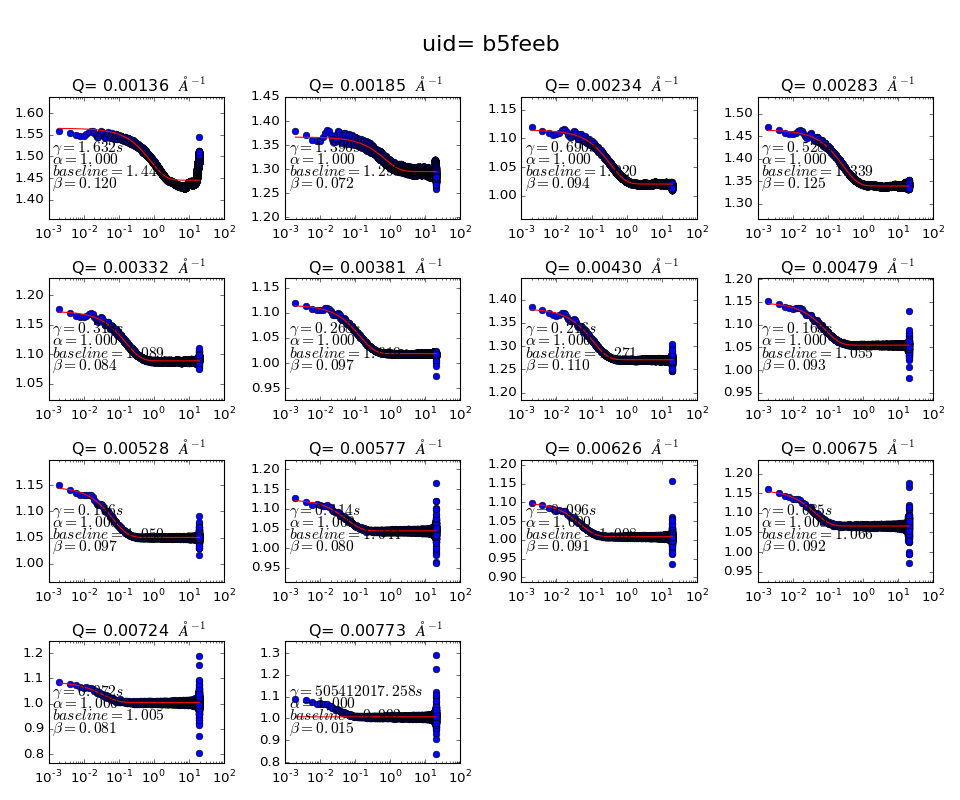

In [54]:
if run_two_time:
    #result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    #fit_q2_rate(  q_ring_center**2, result2['rate'], uid=uid, path= data_dir )
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'stretched',  vlim=[0.95, 1.05], 
                         fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                         guess_values={'baseline':1.0,'beta':0.1,'alpha':1.0,'relaxation_rate':0.01})
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)  

array([ 0.00136419,  0.0018539 ,  0.00234361,  0.00283331,  0.00332302,
        0.00381273,  0.00430244,  0.00479215,  0.00528185,  0.00577156,
        0.00626127,  0.00675098,  0.00724069])

The fitted diffusion coefficient D0 is:  2.64E+05   A^2S-1


<IPython.core.display.Javascript object>


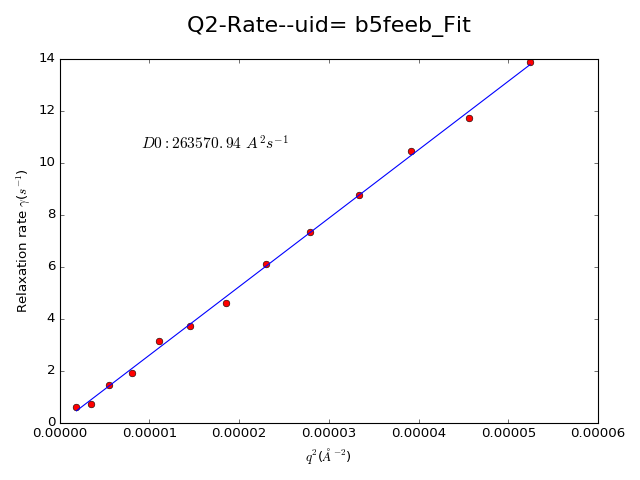

array([  2.63570944e+05,  -3.61346784e-02])

In [59]:
fit_q2_rate(  q_ring_center[:-1]**2, result2['rate'][:-1], uid=uid, path= data_dir )

<IPython.core.display.Javascript object>


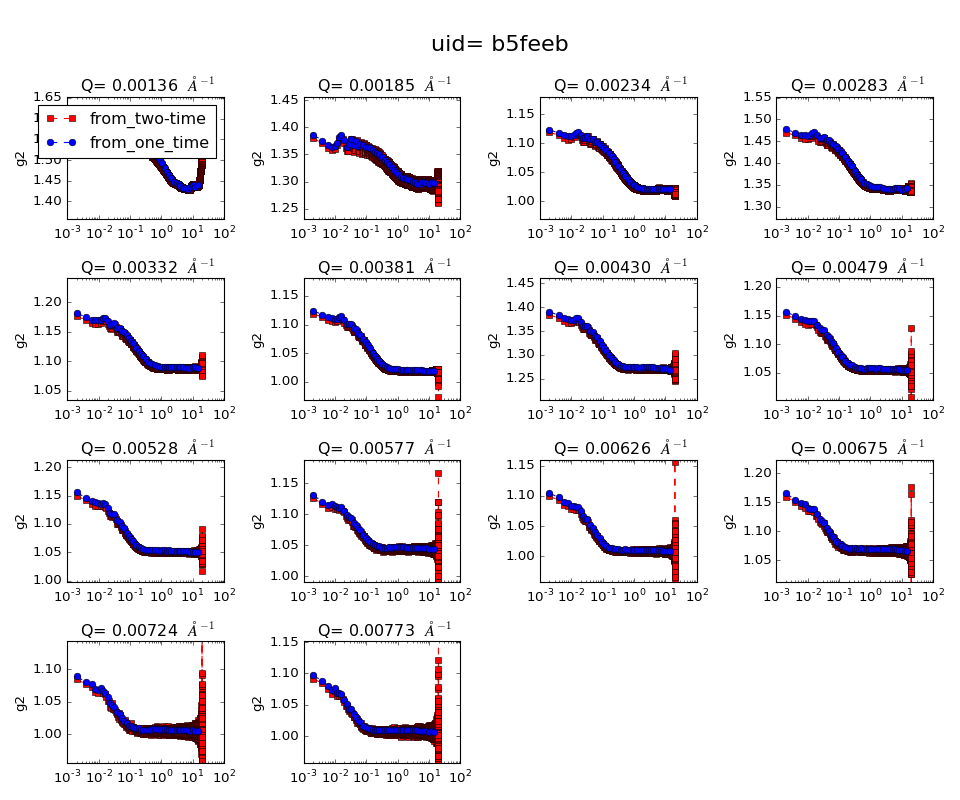

In [60]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid )

# The End!